[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/WoWVED/blob/main/main_design_notebook.ipynb)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        # clean up working directory
        ! rm -rf *

        ! git clone --quiet https://github.com/dominik-strutz/WoWVED tmp
        ! mv tmp/* .
        ! rm -rf tmp
        
        ! pip install -q -r requirements.txt
    
        dependencies_installed = True

In [2]:
import time

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

In [3]:
from helpers.volcano_data_helpers import (
    get_volcano_data,
    fetch_topography_data,
    construct_highly_opinionated_prior
    )

from helpers.plotting_helpers import (
    plot_topography,
    # plot_slice_N,
    # plot_slice_E,
    # plot_marginal_Z,
    plot_prior_model,
    plot_posterior_model,
    plot_design_space_dict,
    plot_design
    )

# General Setup

In [4]:
##################### Choose the volcano #####################
VOLCANO_NAME = 'Etna' # @param {type:"string"}

In [5]:
###################### Get the data #########################
VOLCANO_DATA = get_volcano_data(VOLCANO_NAME)

################# Choose area of interest ####################
# BOUNDING_BOX = dict(
#     min_lon= VOLCANO_DATA['lon'] - 0.15,    # in deg lon
#     max_lon= VOLCANO_DATA['lon'] + 0.15,    # in deg lon
#     min_lat= VOLCANO_DATA['lat'] - 0.15,    # in deg lat
#     max_lat= VOLCANO_DATA['lat'] + 0.15,    # in deg lat
# )
BOUNDING_BOX = dict(
    extent_south = 20.0,                    # in km
    extent_north = 20.0,                    # in km
    extent_west  = 20.0,                    # in km
    extent_east  = 20.0,                    # in km
)

################# Choose the depth range ####################
MIN_DEPTH = -3.0        # km below sea level

# Topography

In [6]:
try:
    with open('.opentopography.txt', 'r') as file:
        api_key = file.read()
except FileNotFoundError:
    api_key = 'demoapikeyot2022'
    print('No API key found. Using demo key.')

# API key for the Open Topography API to fetch the digital elevation model
# api_key = 'demoapikeyot2022'
# This is a demo key which should work for a limited number of requests. If you want to use the API more frequently, or if the key stops working, you can get your own key (see https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets for more information).

# TODO: problems when crossing equator
SURFACE_DATA = fetch_topography_data(VOLCANO_DATA, BOUNDING_BOX, api_key=api_key)

Data loaded from cache


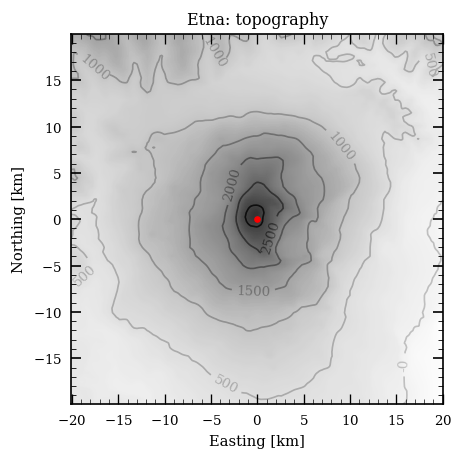

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

plot_topography(ax, SURFACE_DATA['topography'])

ax.scatter(
    SURFACE_DATA.attrs['local_E']*1e-3,
    SURFACE_DATA.attrs['local_N']*1e-3,
    color='red', s=10, label='Volcano')

ax.set_aspect("equal")

ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
ax.set_title(f'{VOLCANO_NAME}: topography')

plt.show()

# Prior Information

Size of the volume data: 67.11 MB


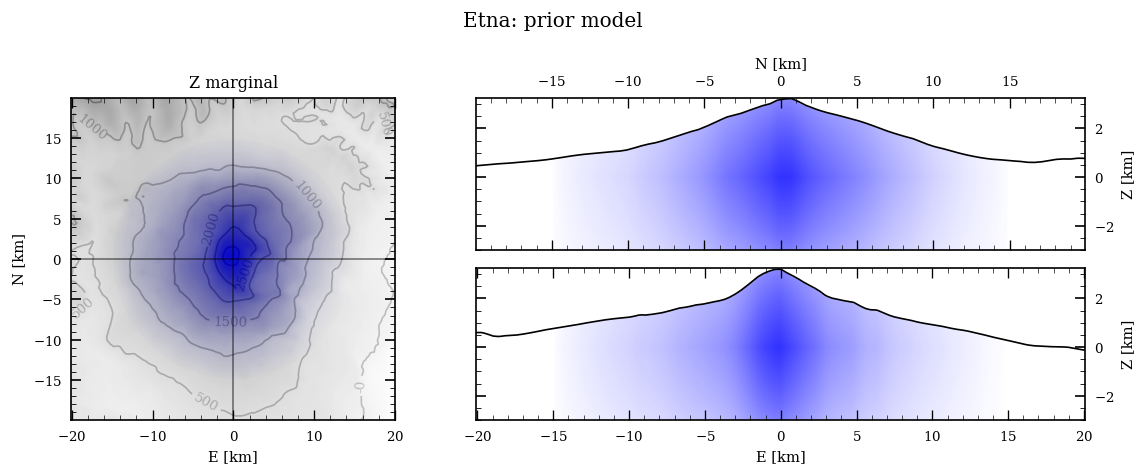

In [8]:
%matplotlib inline
PRIOR_DATA = construct_highly_opinionated_prior(
    VOLCANO_DATA, SURFACE_DATA, MIN_DEPTH,
    center_location=(0.0, 0.0, 0.0),  # km
    max_distance_hor=15.0,  # km
    max_distance_vert=5.0,  # km
)

plot_prior_model(PRIOR_DATA, SURFACE_DATA, VOLCANO_DATA);

In [9]:
################# Calculate Prior Information ################
source_location_mask = PRIOR_DATA.values > 0.0
source_locations = np.meshgrid(
    PRIOR_DATA['E'].values,
    PRIOR_DATA['N'].values,
    PRIOR_DATA['Z'].values,
    indexing='ij'
)
source_locations = np.stack(source_locations, axis=-1)[source_location_mask]

# see https://en.wikipedia.org/wiki/Entropy_(information_theory) for the definition of entropy
prior_mask = PRIOR_DATA.values > 0.0
prior_information = (
    np.log(PRIOR_DATA.values[prior_mask] / PRIOR_DATA.attrs['cell_volume']) * PRIOR_DATA.values[prior_mask] ).sum()

print(f"Prior information: {prior_information:.2f} nats")
# this value in itself is not very informative, but we will make it more informative later on

Prior information: -28.44 nats


# Design Space

We can not plant receivers everywhere and have to therfore restrict the design space. This is of course highly dependent on local circumstance but below we will show a how to implement a number of reasonable design restrictions. This should also make it easy for you to implement your own.

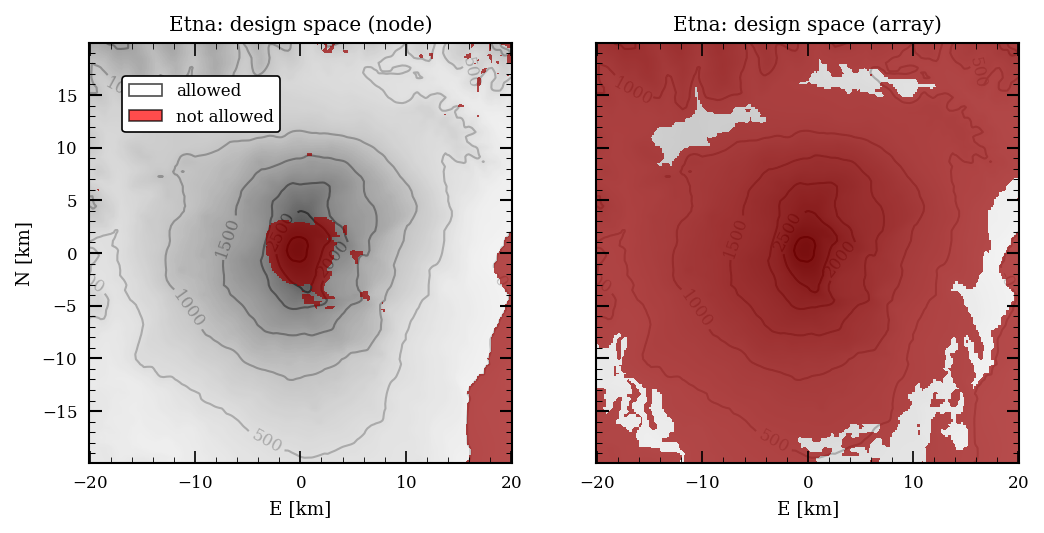

In [10]:
%matplotlib inline
from helpers.design_space_helpers import construct_design_space

design_space_node = construct_design_space(
    SURFACE_DATA,
    max_incline             = 20.0,      # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 3.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0, # km
    )

design_space_array = construct_design_space(
    SURFACE_DATA,
    max_incline             = 3.0,         # degrees,
    exclude_below_sea_level = True,
    # only add a safety margin if the last eruption was within the last 10 years
    safety_margin           = 10.0 if int(VOLCANO_DATA['Last Eruption Year']) >= time.localtime().tm_year-10 else 0.0,  # km,
    min_area                = 10           # km^2 minimum area of the connected region
    )

design_space_dict = dict(
    node=design_space_node,
    array=design_space_array,
)

plot_design_space_dict(design_space_dict, SURFACE_DATA, VOLCANO_DATA);

# Forward Solver

Here we assume a simple homogenous velocity model Therefore both travel times and arrival angles can be calculated analytically. It is also possible to use a more complex forward solver to take a gradient model or a complex velocity model into account, but this is computationally more expensive. In many cases, the simple forward solver is sufficient since there is no information about the subsurface available anyway.

---
#### !!! Warning !!!

We assume here that the geometry of the volcano is a [convex set](https://en.wikipedia.org/wiki/Convex_set) and therefore the straight rays between source and receiver do not intersect the topography. This is typically true on the large scale, but care must be taken when applying this workflow for example in a crater or caldera where the geometry is not a convex set. In this case, the forward solver must be adapted to take the topography into account.

---

Data Types:
* 'PS_diff': Difference between P and S-wave arrival time
* 'ASL': Amplitude of the S-wave
* 'array': Array measurment: backazimuth and apparent velocity

In [11]:
from helpers.forward_function_helpers import Forward_Function

forward_function = Forward_Function(
    vp             = 3500,
    Q              = 50,
    f              = 5.0,
    ps_ratio       = 1/np.sqrt(3),
    tt_std_obs     = 0.01, 
    tt_std_vel     = 0.2,
    asl_std_Q      = 10.0,
    baz_std        = 10.0, 
    # inc_std        = 20.0,
    array_baz_only = True,
    correct_array_orientation=True,
    )

# Experimental Design (Design Criterion)

In [12]:
from helpers.experimental_design_helpers import (
    DN_method,
    NMC_method)

dn_method = DN_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3)
)

nmc_method = NMC_method(
    forward_function,
    PRIOR_DATA,
    n_model_samples=int(1e3)
)

# Experimental Design (Design Optimisation)

In [13]:
# you can easily add already existing stations here to the preexisting_design
#TODO: for now it only works in local coordinates
# preexisting_design = (
#     (['tt', 'asl',], np.array(
#         [ 10.0, 10.0, get_elevation(np.array([ 10.0, 10.0,]), SURFACE_DATA)])),
# )
# for now we will use no preexisting design
preexisting_design = None

GA progress:   0%|          | 0/100 [00:00<?, ?it/s, DN criterion=0]

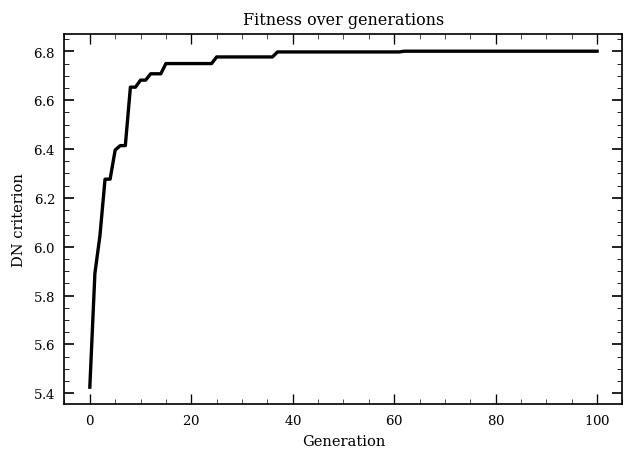

In [14]:
%matplotlib inline
from helpers.experimental_design_helpers import Design_Optimisation

available_stations = dict(
    n_node=3,
    n_array=1)
# available_stations = (('array',), ('array',), ('array',), ('array',))
# available_stations = (('asl',), ('asl',), ('asl',), ('asl',))
# available_stations = (('tt',), ('tt',), ('tt',), ('tt',))

design_optimisation = Design_Optimisation(
    dn_method,
    SURFACE_DATA,
    PRIOR_DATA,
    design_space_dict,
    preexisting_design=preexisting_design
)

best_design, info = design_optimisation.get_optimal_design(
    available_stations=available_stations,
    optimisation_algorithm='genetic',
    optimisation_kwargs=dict(
        num_generations=100,
        num_parents_mating=4,
        plot_progress=True,
        random_seed=0,
    )
)

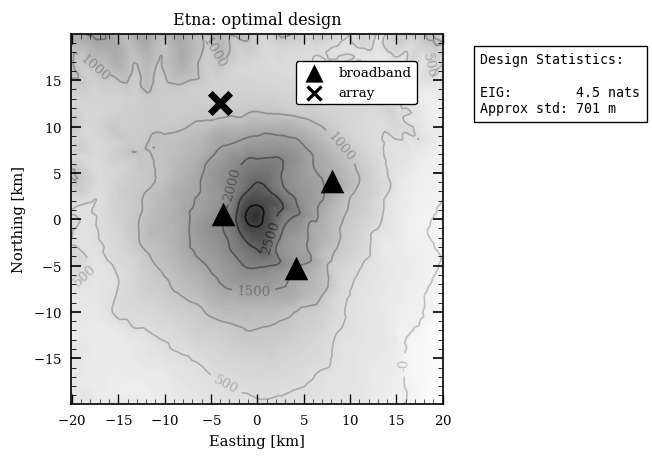

In [15]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 4), dpi=120)

plot_topography(ax, SURFACE_DATA['topography'])
plot_design(ax, best_design)

ax.set_aspect("equal")

torch.manual_seed(0)
eig = nmc_method(best_design)
post_information = eig + prior_information

k = 3
std = np.exp((-post_information - k/2 * (1 + np.log(2*np.pi))) / (0.5 * k * 2))

t = ax.text(
    x=1.1, y=0.95,
    s=f'Design Statistics:\n\nEIG:        {eig:.1f} nats\nApprox std: {std:.0f} m',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax.transAxes,
    fontsize=8,
    fontfamily='monospace',
)
t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='black'))

ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
ax.set_title(f'{VOLCANO_NAME}: optimal design')

plt.show()

In [16]:
# %matplotlib widget

# if IN_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

# plt.ioff()

# from helpers.plotting_helpers import interactive_design_plot

# fig, updated_design = interactive_design_plot(
#     original_design   = best_design,
#     volcano_data      = VOLCANO_DATA,
#     surface_data      = SURFACE_DATA,
#     design_space_dict = design_space_dict,
#     eig_criterion     = nmc_method,
#     prior_information = prior_information,
# )
# # ======================== INTERACTIVE PLOT ========================
# # The plot above shows the optimal design. You can interact with it by moving the stations around.
# # The design is updated in real time and the design statistics are shown in the top right corner.

# # ======================== Careful: ========================
# # The design statistics might update with a delay, especially on an older computer or if running in googl colab.
# # When changing the design to quick the statistics might not update at all. Just reset by running the cell again.
# # If a smooth experience is needed, run the code locally in a jupyter notebook.\nOn my laptop the process is smooth and the statistics update in near real time.

# # Due to the interactive nature of the plot, the following cell will not run automatically. You have to run it manually.
# # Sometimes it does not quite work and you have to run the cell again, change the design and then run the next cell manually.

# display(fig)

In [17]:
updated_design = best_design

In [18]:
print(f"Optimal design: {updated_design}")

Optimal design: [(('tt', 'asl'), array([-3698.31811523,   547.38299561,  1931.14270792])), (('tt', 'asl'), array([8104.82421875, 4143.15478516, 1381.07067235])), (('tt', 'asl'), array([ 4170.44335938, -5237.11962891,  1566.10941128])), (('tt', 'asl', 'array'), array([-4.01306836e+03,  1.25854014e+04,  8.45058328e+02, -3.47809586e-03,
        1.52070124e-02,  9.99878317e-01]))]


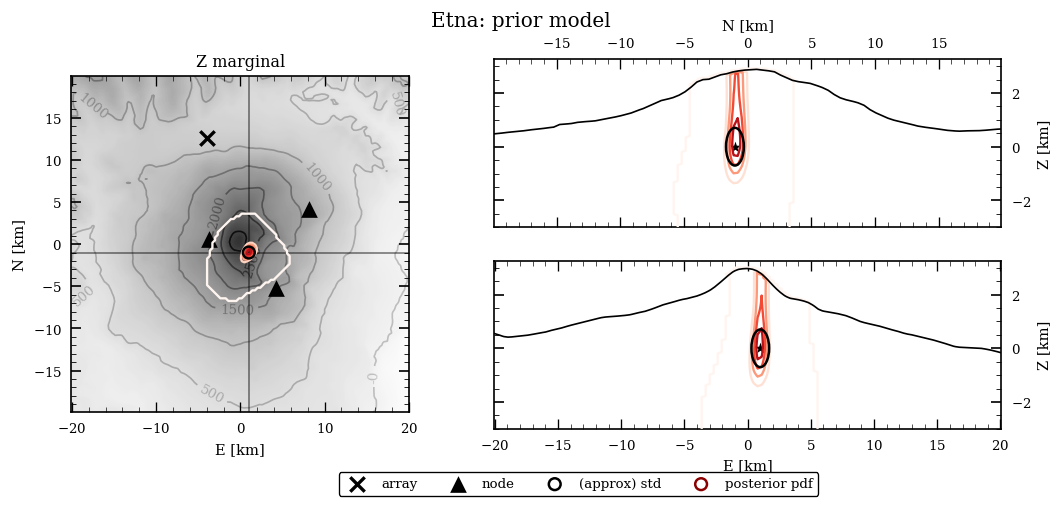

In [19]:
%matplotlib inline

from helpers.posterior_helpers import calculate_posterior, get_posterior_statisics

test_model = np.array([1.0, -1.0, 0.0])*1e3
        
test_prior, test_posterior = calculate_posterior(
    updated_design,
    test_model,
    PRIOR_DATA,
    forward_function,
)

plot_posterior_model(
    updated_design, test_posterior, SURFACE_DATA, VOLCANO_DATA,
    test_model, std=std);

In [20]:
posterior_stats = get_posterior_statisics(test_posterior)

print(f'True model: {test_model*1e-3} m')

with np.printoptions(precision=2):
    print(f"Posterior mode: {(posterior_stats['mode']*1e-3)} km")
    print(f"Posterior mean: {(posterior_stats['mean']*1e-3)} km")
    print(f"Posterior std: {(posterior_stats['std']*1e-3)} km")


True model: [ 1. -1.  0.] m
Posterior mode: [ 1.11 -0.78  0.15] km
Posterior mean: [ 0.98 -0.98  0.54] km
Posterior std: [0.5  0.63 1.15] km
